In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import OneHotEncoder

#Estilizar conteúdo
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)

def estilo_tabelas(df, max_altura='300px', casas_decimais=3):
    return (
        df.style.set_table_styles(
            [
                {'selector': 'thead th', 'props': [('font-size', '12px'), ('text-align', 'center'), ('border-bottom', '2px solid #007BFF')]},
                {'selector': 'td', 'props': [('font-size', '10px'), ('text-align', 'center'), ('max-height', '40px'), ('white-space', 'nowrap'), ('text-overflow', 'ellipsis'), ('overflow', 'hidden'), ('max-width', '100px')]},
                {'selector': 'tr:nth-child(odd)', 'props': [('background-color', '#ffffff')]},
                {'selector': 'table', 'props': [('width', '90%'), ('margin-left', 'auto'), ('margin-right', 'auto'), ('border-collapse', 'collapse')]},
                {'selector': 'td, th', 'props': [('border', '1px solid #666')]},  # Bordas cinza escuro
            ]
        ).set_properties(
            **{'border-color': 'darkgray', 'border-style': 'solid', 'border-width': '1px'}
        ).set_table_attributes(
            f'style="height:auto; overflow:auto; max-height:{max_altura}; display:block;"'  
        ).format(
            precision=casas_decimais  
        )
    )

# Importar a base de dados

object_columns = ['Protocolo_S2iD', 'Nome_Municipio', 'Sigla_UF', 'regiao',
                  'Setores Censitários', 'Status', 'DH_Descricao', 'DM_Descricao',
                  'DA_Descricao', 'DA_Polui/cont da água', 'DA_Polui/cont do ar',
                  'DA_Polui/cont do solo', 'DA_Dimi/exauri hídrico',
                  "DA_Incêndi parques/APA's/APP's", 'PEPL_Descricao', 'PEPR_Descricao',
                  'Categoria', 'Grupo', 'Subgrupo', 'Tipo', 'Subtipo']

dtype = {col: 'object' for col in object_columns}

df_eventos = pd.read_csv(
    "https://raw.githubusercontent.com/brunagmoura/PrevisorReconhecimento/refs/heads/main/df_eventos_desastres_rec_nrec.csv",
    sep=';',
    dtype = dtype,
    decimal=',',
)

estilo_tabelas(df_eventos.head(5))

,Protocolo_S2iD,Nome_Municipio,Sigla_UF,regiao,Data_Registro,Data_Evento,codigo_ibge,Setores Censitários,Status,DH_Descricao,DH_MORTOS,DH_FERIDOS,DH_ENFERMOS,DH_DESABRIGADOS,DH_DESALOJADOS,DH_DESAPARECIDOS,DH_OUTROS AFETADOS,DH_total_danos_humanos,DM_Descricao,DM_Uni Habita Danificadas,DM_Uni Habita Destruidas,DM_Uni Habita Valor,DM_Inst Saúde Danificadas,DM_Inst Saúde Destruidas,DM_Inst Saúde Valor,DM_Inst Ensino Danificadas,DM_Inst Ensino Destruidas,DM_Inst Ensino Valor,DM_Inst Serviços Danificadas,DM_Inst Serviços Destruidas,DM_Inst Serviços Valor,DM_Inst Comuni Danificadas,DM_Inst Comuni Destruidas,DM_Inst Comuni Valor,DM_Obras de Infra Danificadas,DM_Obras de Infra Destruidas,DM_Obras de Infra Valor,DM_total_danos_materiais,DA_Descricao,DA_Polui/cont da água,DA_Polui/cont do ar,DA_Polui/cont do solo,DA_Dimi/exauri hídrico,DA_Incêndi parques/APA's/APP's,PEPL_Descricao,PEPL_Assis_méd e emergên(R$),PEPL_Abast de água pot(R$),PEPL_sist de esgotos sanit(R$),PEPL_Sis limp e rec lixo (R$),PEPL_Sis cont pragas (R$),PEPL_distrib energia (R$),PEPL_Telecomunicações (R$),PEPL_Tran loc/reg/l_curso (R$),PEPL_Distrib combustíveis(R$),PEPL_Segurança pública (R$),PEPL_Ensino (R$),PEPL_total_publico,PEPR_Descricao,PEPR_Agricultura (R$),PEPR_Pecuária (R$),PEPR_Indústria (R$),PEPR_Comércio (R$),PEPR_Serviços (R$),PEPR_total_privado,PE_PLePR,Ano_Evento,Empenhado,DensidadePop,Area,Município - UF,PIB,DOMICILIO_AREARURAL,PDEFAGUA,PDEFESGOTO,PDEFLIXO,PDEFSAN,QTDE_FAMILIAS_ATUALIZADAS,Categoria,Grupo,Subgrupo,Tipo,Subtipo,COBRADE,Pop
0,SP-A-3550001-12200-20100101,São Luiz do Paraitinga,SP,Sudeste,2010-01-01,2010-01-01,3550001,nan,Reconhecido,nan,0,0,0,93,4030,0,16,4139,nan,49,20,20643486.932,3.000,0,1121928.638,9.000,1,5235666.976,0,0,0.000,3,3,32411.272,25.000,0.000,65321178.458,92354672.275,nan,nan,nan,nan,nan,nan,nan,7978.159,673157.183,623293.688,2493.175,0.000,330993.880,3739.762,58609.552,0.000,0.000,1087024.191,2787289.589,nan,1642902.433,1149353.560,379785.310,0.000,24433.113,3196474.416,5983764.005,2010,nan,nan,nan,São Luiz do Paraitinga - SP,86448.000,nan,nan,nan,nan,nan,nan,Natural,Hidrológico,Enxurradas,nan,nan,12200,10397.000
1,SP-A-3518305-11321-20100101,Guararema,SP,Sudeste,2010-01-01,2010-01-01,3518305,nan,Reconhecido,nan,4,2,0,66,417,0,14430,14919,nan,161,91,18604069.987,0.000,0,0.000,2.000,0,24931.748,0,0,0.000,0,0,37397.621,9000.000,0.000,57771845.314,76438244.669,nan,nan,nan,nan,nan,nan,nan,0.000,179508.582,264276.524,12465.874,0.000,349044.465,74795.243,134631.437,0.000,0.000,77288.417,1092010.541,nan,441291.931,2049389.645,0.000,0.000,112192.889,2602874.464,3694885.005,2010,nan,nan,nan,Guararema - SP,1111405.000,nan,nan,nan,nan,nan,nan,Natural,Geológico,Movimento de massa,Deslizamentos,Deslizamentos de solo e ou rocha,11321,25844.000
2,BA-A-2905909-14110-20100101,Campo Alegre de Lourdes,BA,Nordeste,2010-01-01,2010-01-01,2905909,nan,Reconhecido,nan,0,0,0,0,0,0,0,0,nan,0,0,0.000,0.000,0,0.000,0.000,0,0.000,0,0,0.000,0,0,0.000,0.000,0.000,0.000,0.000,nan,nan,nan,nan,nan,nan,nan,747.952,448771.455,0.000,0.000,0.000,0.000,0.000,249317.475,0.000,0.000,177015.407,875852.290,nan,254303.825,147097.310,0.000,0.000,0.000,401401.135,1277253.425,2010,nan,9.638,2914.587,Campo Alegre de Lourdes - BA,107459.000,nan,nan,nan,nan,nan,nan,Natural,Climatológico,Seca,Estiagem,nan,14110,28090.000
3,SP-A-3513603-12100-20100101,Cunha,SP,Sudeste,2010-01-01,2010-01-01,3513603,nan,Reconhecido,nan,6,0,0,38,492,0,12000,12536,nan,89,9,3340854.165,0.000,0,0.000,0.000,0,0.000,0,0,0.000,0,0,0.000,3.000,400.000,8052097.614,11392951.779,nan,nan,nan,nan,nan,nan,nan,0.000,1246.587,0.000,0.000,0.000,1994539.800,0.000,125656.007,0.000,0.000,0.000,2121442.395,nan,49863.495,1383711.986,0.000,0.000,925466.467,2359041.949,4480484.344,2010,nan,15.538,1407.250,Cunha - SP,112225.000,nan,nan,nan,nan,nan,nan,Natural,Hidrológico,Inundações,nan,nan,12100,21866.000
4,BA-P-2917334-12200-20100101,Iuiu,BA,Nordeste,2010-01-01,2010-01-01,2917334,nan,Reconhecido,nan,0,0,0,0,0,0,0,0,

In [2]:
# Remover colunas com mais de 50% de dados ausentes
colunas_para_remover = [
    'Protocolo_S2iD', 'Nome_Municipio', 'Sigla_UF', 'Data_Registro', 'Data_Evento', 'codigo_ibge', 
    'Setores Censitários', 'DH_Descricao', 'DM_Descricao', 'DA_Descricao', 'DA_Polui/cont da água', 
    'DA_Polui/cont do ar', 'DA_Polui/cont do solo', 'DA_Dimi/exauri hídrico', 'PEPL_Descricao', 'DA_Incêndi parques/APA\'s/APP\'s', 
    'PEPR_Descricao', 'Ano_Evento', 'Empenhado', 'Município - UF', 'Subgrupo', 'Tipo', 'Subtipo', 'COBRADE'
]

df_eventos_limpa = df_eventos.drop(columns=colunas_para_remover)

# Remover linhas com NA
df_eventos_limpa = df_eventos_limpa.dropna()

# Encoding das variáveis categóricas mantidas
categorias = ['regiao', 'Categoria', 'Grupo']
df_eventos_limpa = pd.get_dummies(df_eventos_limpa, columns=categorias, drop_first=False, dtype=int)

# Shuffle das linhas porque os eventos são registrados por sequência temporal
df_eventos_limpa = df_eventos_limpa.sample(frac=1, random_state=1).reset_index(drop=True)

# Encoding da variável target
df_eventos_limpa['Status'] = df_eventos_limpa['Status'].map({'Reconhecido': 0, 'Não reconhecido': 1})

print("Antes, a base de dados possuia a seguinte dimensão:", df_eventos.shape)
print("Após a eliminação das colunas com mais de 50% de dados ausentes e das linhas com dados ausentes, a base de dados passou a ter a seguinte dimensão:", df_eventos_limpa.shape)
estilo_tabelas(df_eventos_limpa.head(5))

Antes, a base de dados possuia a seguinte dimensão: (26258, 84)
Após a eliminação das colunas com mais de 50% de dados ausentes e das linhas com dados ausentes, a base de dados passou a ter a seguinte dimensão: (5474, 73)


,Status,DH_MORTOS,DH_FERIDOS,DH_ENFERMOS,DH_DESABRIGADOS,DH_DESALOJADOS,DH_DESAPARECIDOS,DH_OUTROS AFETADOS,DH_total_danos_humanos,DM_Uni Habita Danificadas,DM_Uni Habita Destruidas,DM_Uni Habita Valor,DM_Inst Saúde Danificadas,DM_Inst Saúde Destruidas,DM_Inst Saúde Valor,DM_Inst Ensino Danificadas,DM_Inst Ensino Destruidas,DM_Inst Ensino Valor,DM_Inst Serviços Danificadas,DM_Inst Serviços Destruidas,DM_Inst Serviços Valor,DM_Inst Comuni Danificadas,DM_Inst Comuni Destruidas,DM_Inst Comuni Valor,DM_Obras de Infra Danificadas,DM_Obras de Infra Destruidas,DM_Obras de Infra Valor,DM_total_danos_materiais,PEPL_Assis_méd e emergên(R$),PEPL_Abast de água pot(R$),PEPL_sist de esgotos sanit(R$),PEPL_Sis limp e rec lixo (R$),PEPL_Sis cont pragas (R$),PEPL_distrib energia (R$),PEPL_Telecomunicações (R$),PEPL_Tran loc/reg/l_curso (R$),PEPL_Distrib combustíveis(R$),PEPL_Segurança pública (R$),PEPL_Ensino (R$),PEPL_total_publico,PEPR_Agricultura (R$),PEPR_Pecuária (R$),PEPR_Indústria (R$),PEPR_Comércio (R$),PEPR_Serviços (R$),PEPR_total_privado,PE_PLePR,DensidadePop,Area,PIB,DOMICILIO_AREARURAL,PDEFAGUA,PDEFESGOTO,PDEFLIXO,PDEFSAN,QTDE_FAMILIAS_ATUALIZADAS,Pop,regiao_Centro-oeste,regiao_Nordeste,regiao_Norte,regiao_Sudeste,regiao_Sul,Categoria_Natural,Categoria_Tecnológico,Grupo_Biológico,Grupo_Climatológico,Grupo_Desastres Relacionados a Incêndios Urbanos,Grupo_Desastres Relacionados a Produtos Perigosos,Grupo_Desastres relacionados a obras civis,Grupo_Desastres relacionados a transporte de passageiros e cargas não perigosas,Grupo_Geológico,Grupo_Hidrológico,Grupo_Meteorológico
0,0,0,0,0,35,45,0,1500,1580,9,5,1178172.274,0.000,0,0.000,0.000,0,0.000,0,0,0.000,0,0,0.000,0.000,0.000,0.000,1178172.274,0.000,0.000,50783.288,25391.644,0.000,0.000,0.000,43673.627,0.000,0.000,0.000,119848.559,8125326.025,2031331.506,0.000,0.000,0.000,10156657.532,10276506.091,17.397,912.222,119609.000,0.753,0.708,0.988,0.724,0.679,243.000,15870.000,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,60,450,0,5205,5715,497,0,4754583.015,0.000,0,0.000,2.000,0,252457.835,0,0,0.000,0,0,0.000,8.000,0.000,12289688.271,17296729.121,0.000,0.000,77728.344,275038.756,0.000,0.000,0.000,538119.305,0.000,0.000,0.000,890886.405,66009.301,300868.483,0.000,0.000,0.000,366877.784,1257764.189,79.983,155.058,407247.000,0.360,0.040,0.000,0.000,0.000,25.000,12402.000,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,45228,45228,0,0,0.000,0.000,0,0.000,0.000,0,0.000,0,0,0.000,0,0,0.000,0.000,0.000,0.000,0.000,0.000,183556.082,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,183556.082,0.000,0.000,0.000,0.000,0.000,0.000,183556.082,51.952,864.349,752944.000,0.126,0.231,0.084,0.105,0.055,238.000,44905.000,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0.000,0.000,0,0.000,0.000,0,0.000,0,0,0.000,0,0,0.000,0.000,0.000,0.000,0.000,0.000,73592.737,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,73592.737,147185.473,735927.367,0.000,0.000,0.000,883112.841,956705.577,24.149,156.568,70207.000,0.476,0.381,0.905,0.476,0.333,21.000,3781.000,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,1385,1385,0,0,0.000,0.000,0,0.000,0.000,0,0.000,0,0,0.000,0,0,0.000,0.000,0.000,0.000,0.000,0.000,211947.082,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,211947.082,229609.339,213418.936,0.000,0.000,0.000,443028.275,654975.357,14.104,261.194,43757.000,0.208,0.125,0.583,0.167,0.083,24.000,3684.000,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0


In [3]:
# Balanceamento da variável target

status_counts = df_eventos_limpa['Status'].value_counts()
print("\nBalanceamento da variável 'Status':")
display(status_counts)


Balanceamento da variável 'Status':


Status
0    4998
1     476
Name: count, dtype: int64

In [4]:
X = df_eventos_limpa.drop('Status', axis=1)

y = df_eventos_limpa['Status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

In [5]:
# Criar pipeline com normalização e modelo de Regressão Logística
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(random_state=1, solver='lbfgs'))
])

# Definir hiperparâmetros para o Grid Search
param_grid = {
    'logreg__C': [0.01, 0.1, 1, 10],  
    'logreg__max_iter': [1000],  
    'logreg__fit_intercept': [True, False],  
    'logreg__tol': [1e-4, 1e-3],  # Tolerância para convergência
    'logreg__penalty': ['l1', 'l2'],  # Tipos de penalidade
}

# Grid Search com validação cruzada
grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='f1_weighted', n_jobs=-1)
1
grid_search.fit(X_train, y_train)

# Melhor modelo encontrado
logreg_best = grid_search.best_estimator_

print(f"Melhores hiperparâmetros: {grid_search.best_params_}")

y_pred = logreg_best.predict(X_test)

# Classification report

classification_report = metrics.classification_report(y_test, y_pred, digits=6, target_names=['Reconhecido', 'Não reconhecido'])
print('Classification report para modelo "base" (sem balanceamento): \n')
print(classification_report)

Melhores hiperparâmetros: {'logreg__C': 10, 'logreg__fit_intercept': True, 'logreg__max_iter': 1000, 'logreg__penalty': 'l2', 'logreg__tol': 0.001}
Classification report para modelo "base" (sem balanceamento): 

                 precision    recall  f1-score   support

    Reconhecido   0.923507  0.990000  0.955598      1000
Não reconhecido   0.565217  0.136842  0.220339        95

       accuracy                       0.915982      1095
      macro avg   0.744362  0.563421  0.587969      1095
   weighted avg   0.892423  0.915982  0.891809      1095



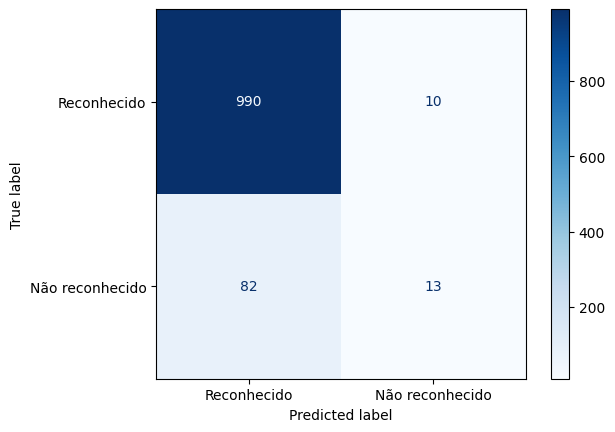

In [6]:
ConfusionMatrixDisplay.from_estimator(grid_search, X_test, y_test, 
                                      values_format='d', cmap='Blues', display_labels=['Reconhecido', 'Não reconhecido'])

In [7]:
X_smote = df_eventos_limpa.drop('Status', axis=1)

y_smote = df_eventos_limpa['Status']

X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(X_smote, y_smote, test_size=0.2, random_state=1, stratify=y)

In [8]:
smote = SMOTE(random_state=1)
X_train_smote, y_train_smote = smote.fit_resample(X_train_smote, y_train_smote)

pipeline_smote = Pipeline([
    ('scaler', StandardScaler()), 
    ('logreg', LogisticRegression(random_state=1, solver='lbfgs'))  
])

# Definir hiperparâmetros para o Grid Search
param_grid_smote = {
    'logreg__C': [0.01, 0.1, 1, 10],  
    'logreg__max_iter': [1000],  
    'logreg__fit_intercept': [True, False],
    'logreg__tol': [1e-4, 1e-3],
    'logreg__penalty': ['l1', 'l2'],
}

# Grid Search com validação cruzada
grid_search_smote = GridSearchCV(pipeline_smote, param_grid_smote, cv=3, scoring='f1_weighted', n_jobs=-1)

# Treinar o pipeline com Grid Search
grid_search_smote.fit(X_train_smote, y_train_smote)

# Melhor modelo encontrado
logreg_best_smote = grid_search_smote.best_estimator_

print(f"Melhores hiperparâmetros: {grid_search_smote.best_params_}")

# Classification report
y_pred_smote = logreg_best_smote.predict(X_test_smote)

classification_report_smote = metrics.classification_report(y_test_smote, y_pred_smote, digits=6, target_names=['Reconhecido', 'Não reconhecido'])
print('Classification report para modelo base com balanceamento smote: \n')
print(classification_report_smote)

Melhores hiperparâmetros: {'logreg__C': 1, 'logreg__fit_intercept': True, 'logreg__max_iter': 1000, 'logreg__penalty': 'l2', 'logreg__tol': 0.0001}
Classification report para modelo base com balanceamento smote: 

                 precision    recall  f1-score   support

    Reconhecido   0.934761  0.960000  0.947213      1000
Não reconhecido   0.411765  0.294737  0.343558        95

       accuracy                       0.902283      1095
      macro avg   0.673263  0.627368  0.645385      1095
   weighted avg   0.889387  0.902283  0.894841      1095



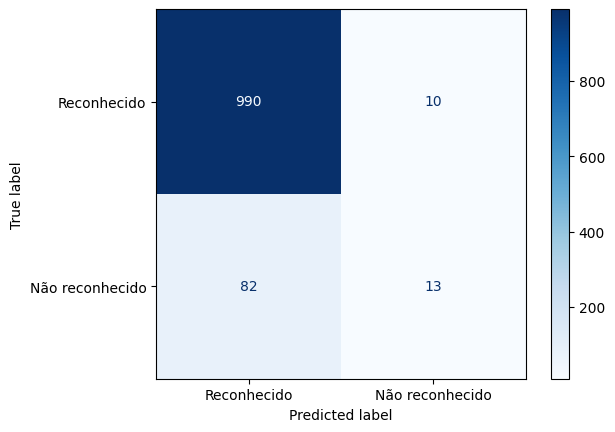

In [9]:
ConfusionMatrixDisplay.from_estimator(grid_search, X_test_smote, y_test, 
                                      values_format='d', cmap='Blues', display_labels=['Reconhecido', 'Não reconhecido'])